# Generate test COVID Data

This Jupyter notebook uses the 'real' COVID data file format but constructs much simpler "test" datasets to allow QA of the routines to read in the COVID data.

It uses the same library used to retrieve the original data, then pulls out subsets of the data and replaces the real data with known quantities.

In [1]:
# This forces a reload of any external library file if it changes.  
# Useful when developing external libraries since otherwise Jupyter 
# will not re-import any library without restarting the python kernel.

%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import date, timedelta, datetime

# Import COVID data retrieval routines from external python library
import COVIDlib.collectors as COVIDdata

In [3]:
# Mark the start of processing
start = time.perf_counter()

## Define variables of interest below
data_dir = 'our_data/'    # Data directory for the COVID datafiles
test_dir = 'test_data/'   # Data directory for storing test datafiles

## Define FIPS corresponding to various local areas
ClayFIPS = 27027
CassFIPS = 38017
MNFIPS = 27
NDFIPS = 38

## Check if data directory exists, if not, create it
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
        
## Create test directory if necessary
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

In [4]:
##
## This generator function was added for creating testing data
##
def daterange(date1, date2):
    # Initial version of Generator Code for date range grabbed from 
    # https://www.w3resource.com/python-exercises/date-time-exercise/python-date-time-exercise-50.php
    for n in range(int ((date2 - date1).days)+1):
        yield (date1 + timedelta(n)).strftime("%Y-%m-%d")

# Generate Test John Hopkins Data

In [5]:
## 
## Retrieve the US Census data and then John Hopkins data
##

# Retrieve needed Census Bureau data first
(cnty_pop_df, state_pop_df) = COVIDdata.retrieve_census_population_data()

# Retrieve John Hopkins data
(ts_us_confirmed_df, ts_us_dead_df, combined_cnty_df, combined_state_df) = COVIDdata.retrieve_John_Hopkins_data(cnty_pop_df, state_pop_df)

In [6]:
##
## Create test county-level dataset by limiting combined_cnty_df to Cass and Clay counties and replacing real data with
## generated data for the two counties.
##
    
test_combined_cnty_df = combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS) | (combined_cnty_df['FIPS'] == CassFIPS)].copy()

# Generate a test dataset
date1 = date(2020, 3, 22)
date2 = date(2020, 6, 1)
dates = list(daterange(date1, date2))

# Assume an unreal situation of 10 new cases a day from March 22 to June 1 
# to allow easy check of read in numbers.
confirmed_list = len(dates)*[10]
confirmed_CLAY = np.array(confirmed_list)  # New infections each day
cumilative_CLAY = np.cumsum(confirmed_CLAY)  # Cumilative number of infections
cumilative_CLAY_list = cumilative_CLAY.tolist()

# To compute 'recovered' folks assume 90% of those known to be infected survive and recover after 2 weeks
delay = 14 # days
survival_rate = 0.9 # Assume 10% of known infections die
twowks_CLAY = np.array(delay*[0] + cumilative_CLAY_list[0:-delay])  # Compute number who are 2 weeks past infection
recovered_CLAY = np.floor(survival_rate*twowks_CLAY).astype(int)
recovered_CLAY_list = recovered_CLAY.tolist()
deaths_CLAY =  twowks_CLAY - recovered_CLAY
deaths_CLAY_list = deaths_CLAY.tolist()

# Assume Cass County has twice the cases
confirmed_CASS = 2*confirmed_CLAY
cumilative_CASS = np.cumsum(confirmed_CASS)  # Cumilative number of infections
cumilative_CASS_list = cumilative_CASS.tolist()
twowks_CASS = np.array(delay*[0] + cumilative_CASS_list[0:-delay])  # Compute number who are 2 weeks past infection
recovered_CASS = np.floor(survival_rate*twowks_CASS).astype(int)
recovered_CASS_list = recovered_CASS.tolist()
deaths_CASS =  twowks_CASS - recovered_CASS
deaths_CASS_list = deaths_CASS.tolist()

# Save Dates, Confirmed, Deaths, Recovered numbers
test_combined_cnty_df['Dates'] = 2*[dates]
test_combined_cnty_df['Confirmed'] = [cumilative_CLAY_list, cumilative_CASS_list ]
test_combined_cnty_df['Deaths'] = [deaths_CLAY_list, deaths_CASS_list ]
test_combined_cnty_df['Recovered'] = [recovered_CLAY_list, recovered_CASS_list ]

##
## Compute derivatives and second derivatives
##

# Convert the list of dates into numpy array of days since Jan. 1, 2020 for each observation
dates = test_combined_cnty_df[test_combined_cnty_df['FIPS'] == ClayFIPS]['Dates'].tolist()[0]
dates_list = []
for dat in dates:
    dates_list.append( COVIDdata.iso2days(dat) )
dates_arr = np.array([dates_list]*len(test_combined_cnty_df))

# Convert confirmed/deaths/recovered into arrays
confirmed_arr = np.array(test_combined_cnty_df['Confirmed'].values.tolist())
deaths_arr = np.array(test_combined_cnty_df['Deaths'].values.tolist())

# Compute the derivatives (using forward derivative approach)
dconfirmed_arr = COVIDdata.derivative(dates_arr, confirmed_arr)
ddeaths_arr = COVIDdata.derivative(dates_arr, deaths_arr)

# Compute the second derivatives (a bit hinky to use forward derivative again, but...)
d2confirmed_arr = COVIDdata.derivative(dates_arr, dconfirmed_arr)
d2deaths_arr = COVIDdata.derivative(dates_arr, ddeaths_arr)

# Convert numpy arrays to lists of lists for storage in combined dataframe
test_combined_cnty_df['dConfirmed'] = dconfirmed_arr.tolist()
test_combined_cnty_df['d2Confirmed'] = d2confirmed_arr.tolist()
test_combined_cnty_df['dDeaths'] = ddeaths_arr.tolist()
test_combined_cnty_df['d2Deaths'] = d2deaths_arr.tolist()

In [7]:
##
## Create test state-level dataset by limiting combined_state_df to Minnesota and North Dakora and replacing real data with
## generated data for the two states.
##
    
test_combined_states_df = combined_state_df[(combined_state_df['FIPS'] == MNFIPS) | (combined_state_df['FIPS'] == NDFIPS)].copy()

# Generate a test dataset
date1 = date(2020, 3, 22)
date2 = date(2020, 6, 1)
dates = list(daterange(date1, date2))

# Assume an unreal situation of 10 additional new cases a day from March 22 to June 1 
# to allow easy check of read in numbers.
rise = (10*np.arange(len(dates))).tolist()
confirmed_list = rise + (len(dates) - len(rise))*[rise[-1]]
confirmed_MN = np.array(confirmed_list)  # New infections each day
cumilative_MN = np.cumsum(confirmed_MN)  # Cumilative number of infections
cumilative_MN_list = cumilative_MN.tolist()

# To compute 'recovered' folks assume 90% of those known to be infected survive and recover after 2 weeks
delay = 14 # days
survival_rate = 0.9 # Assume 10% of known infections die
twowks_MN= np.array(delay*[0] + cumilative_MN_list[0:-delay])  # Compute number who are 2 weeks past infection
recovered_MN = np.floor(survival_rate*twowks_MN).astype(int)
recovered_MN_list = recovered_MN.tolist()
deaths_MN =  twowks_MN - recovered_MN
deaths_MN_list = deaths_MN.tolist()

# Assume North Dakota has half the cases
confirmed_ND = 0.5*confirmed_MN
cumilative_ND = np.cumsum(confirmed_ND)  # Cumilative number of infections
cumilative_ND_list = cumilative_ND.tolist()
twowks_ND = np.array(delay*[0] + cumilative_ND_list[0:-delay])  # Compute number who are 2 weeks past infection
recovered_ND = np.floor(survival_rate*twowks_ND).astype(int)
recovered_ND_list = recovered_ND.tolist()
deaths_ND =  twowks_ND - recovered_ND
deaths_ND_list = deaths_ND.tolist()

# Save Dates, Confirmed, Deaths, Recovered numbers
test_combined_states_df['Dates'] = 2*[dates]
test_combined_states_df['Confirmed'] = [cumilative_MN_list, cumilative_ND_list ]
test_combined_states_df['Deaths'] = [deaths_MN_list, deaths_ND_list ]
test_combined_states_df['Recovered'] = [recovered_MN_list, recovered_ND_list ]

##
## Compute derivatives and second derivatives
##

# Convert the list of dates into numpy array of days since Jan. 1, 2020 for each observation
dates = test_combined_states_df[test_combined_states_df['FIPS'] == MNFIPS]['Dates'].tolist()[0]
dates_list = []
for dat in dates:
    dates_list.append( COVIDdata.iso2days(dat) )
dates_arr = np.array([dates_list]*len(test_combined_states_df))

# Convert confirmed/deaths/recovered into arrays
confirmed_arr = np.array(test_combined_states_df['Confirmed'].values.tolist())
deaths_arr = np.array(test_combined_states_df['Deaths'].values.tolist())

# Compute the derivatives (using forward derivative approach)
dconfirmed_arr = COVIDdata.derivative(dates_arr, confirmed_arr)
ddeaths_arr = COVIDdata.derivative(dates_arr, deaths_arr)

# Compute the second derivatives (a bit hinky to use forward derivative again, but...)
d2confirmed_arr = COVIDdata.derivative(dates_arr, dconfirmed_arr)
d2deaths_arr = COVIDdata.derivative(dates_arr, ddeaths_arr)

# Convert numpy arrays to lists of lists for storage in combined dataframe
test_combined_states_df['dConfirmed'] = dconfirmed_arr.tolist()
test_combined_states_df['d2Confirmed'] = d2confirmed_arr.tolist()
test_combined_states_df['dDeaths'] = ddeaths_arr.tolist()
test_combined_states_df['d2Deaths'] = d2deaths_arr.tolist()

# Generate incident rates and death rates per 100000
pop_arr = np.array(test_combined_states_df['PopEst2019'].values.tolist())
test_combined_states_df['Incident_Rate'] = np.around(100000*(confirmed_arr/pop_arr[:, np.newaxis]), decimals=3).tolist()
test_combined_states_df['Mortality_Rate'] = np.around(100000*(deaths_arr/pop_arr[:, np.newaxis]), decimals=3).tolist()

# Generate people hospitalized amd hospitalization rate
# Assume 10% of those currently sick are in the hospital
hospitalized_MN = np.floor(0.1*(cumilative_MN - recovered_MN)).astype(int).tolist()
hospitalized_ND = np.floor(0.1*(cumilative_ND - recovered_ND)).astype(int).tolist()  
                           
# Generate people tested
test_combined_states_df['People_Hospitalized'] = [ hospitalized_MN, hospitalized_ND]
hospitalized_arr = np.array(test_combined_states_df['People_Hospitalized'].values.tolist())
test_combined_states_df['Hospitalization_Rate'] = np.around(100000*(hospitalized_arr/pop_arr[:, np.newaxis]), decimals=3).tolist()

# Generate testing rate
# Assume completely bogus flat rates of 5000 people a day tested
tested_list = len(dates)*[5000]
tested_arr = np.array(tested_list)  # New tests each day
cumilative_tested_arr = np.cumsum(tested_arr)  # Cumilative number of tests
cumilative_tested_list = cumilative_tested_arr.tolist()
test_combined_states_df['People_Tested'] = 2*[cumilative_tested_list]
test_combined_states_df['Testing_Rate'] = np.around(100000*(cumilative_tested_arr/pop_arr[:, np.newaxis]), decimals=3).tolist()

In [8]:
#
# Save the county and state-level test dataframes into CSV files
#
combined_datafile = test_dir + "TEST_countylevel_combinedCDR.csv"
print(" - John Hopkins county level test data exported to ", combined_datafile)
test_combined_cnty_df.to_csv(combined_datafile, index=False)

combined_datafile = test_dir + "TEST_statelevel_combinedCDR.csv"
print(" - John Hopkins state level test data exported to ", combined_datafile)
test_combined_states_df.to_csv(combined_datafile, index=False)

#
# Save the same data to pickle files
#
combined_datafile = test_dir + "TEST_countylevel_combinedCDR.p"
print(" - John Hopkins county level test data also exported to ", combined_datafile)
with open(combined_datafile, 'wb') as pickle_file:
    pickle.dump(test_combined_cnty_df, pickle_file)
    pickle_file.close()

combined_datafile = test_dir + "TEST_statelevel_combinedCDR.p"
print(" - John Hopkins state level test data also exported to ", combined_datafile)
with open(combined_datafile, 'wb') as pickle_file:
    pickle.dump(test_combined_states_df, pickle_file)
    pickle_file.close()

 - John Hopkins county level test data exported to  test_data/TEST_countylevel_combinedCDR.csv
 - John Hopkins state level test data exported to  test_data/TEST_statelevel_combinedCDR.csv
 - John Hopkins county level test data also exported to  test_data/TEST_countylevel_combinedCDR.p
 - John Hopkins state level test data also exported to  test_data/TEST_statelevel_combinedCDR.p


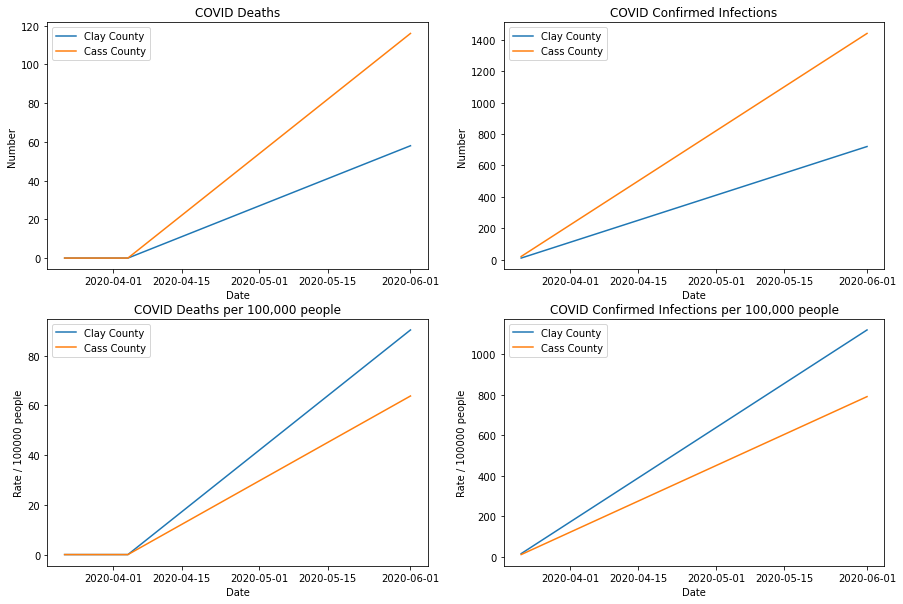

In [9]:
# Show demonstrations of plotting this data here by producing plots of data for Cass and Clay counties and North Dakota and Minnesota
combined_cnty_df = test_combined_cnty_df.copy()
combined_state_df = test_combined_states_df.copy()

#
# I will pull the data to plot into numpy arrays (notice I have to use [0] because it comes out at list of lists even for single row)
#

# County-level data for plotting
dates_cty = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['Dates'].to_list()[0], dtype='datetime64')
clay_deaths = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['Deaths'].to_list()[0],dtype='int')
clay_death_rate = (clay_deaths/combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['PopEst2019'].values)*100000
cass_deaths = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == CassFIPS)]['Deaths'].to_list()[0],dtype='int')
cass_death_rate = (cass_deaths/combined_cnty_df[(combined_cnty_df['FIPS'] == CassFIPS)]['PopEst2019'].values)*100000
clay_confirmed = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['Confirmed'].to_list()[0],dtype='int')
clay_confirmed_rate = (clay_confirmed/combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['PopEst2019'].values)*100000
cass_confirmed = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == CassFIPS)]['Confirmed'].to_list()[0],dtype='int')
cass_confirmed_rate = (cass_confirmed/combined_cnty_df[(combined_cnty_df['FIPS'] == CassFIPS)]['PopEst2019'].values)*100000

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))

# Plot up deaths and death rates as plots 0 and 1
this_axs = axs[0, 0]  # Row 0, column 0
this_axs.plot(dates_cty, clay_deaths, label='Clay County')
this_axs.plot(dates_cty, cass_deaths, label='Cass County')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Number")
title = this_axs.set_title("COVID Deaths")

this_axs = axs[1, 0]  # Row 1, column 0
this_axs.plot(dates_cty, clay_death_rate, label='Clay County')
this_axs.plot(dates_cty, cass_death_rate, label='Cass County')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Rate / 100000 people")
title = this_axs.set_title("COVID Deaths per 100,000 people")

# Plot up confirmed infections and infection rates as plots 2 and 3
this_axs = axs[0, 1]  # Row 0, column 1
this_axs.plot(dates_cty, clay_confirmed, label='Clay County')
this_axs.plot(dates_cty, cass_confirmed, label='Cass County')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Number")
title = this_axs.set_title("COVID Confirmed Infections")

this_axs = axs[1, 1]  # Row 1, column 1
this_axs.plot(dates_cty, clay_confirmed_rate, label='Clay County')
this_axs.plot(dates_cty, cass_confirmed_rate, label='Cass County')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Rate / 100000 people")
title = this_axs.set_title("COVID Confirmed Infections per 100,000 people")

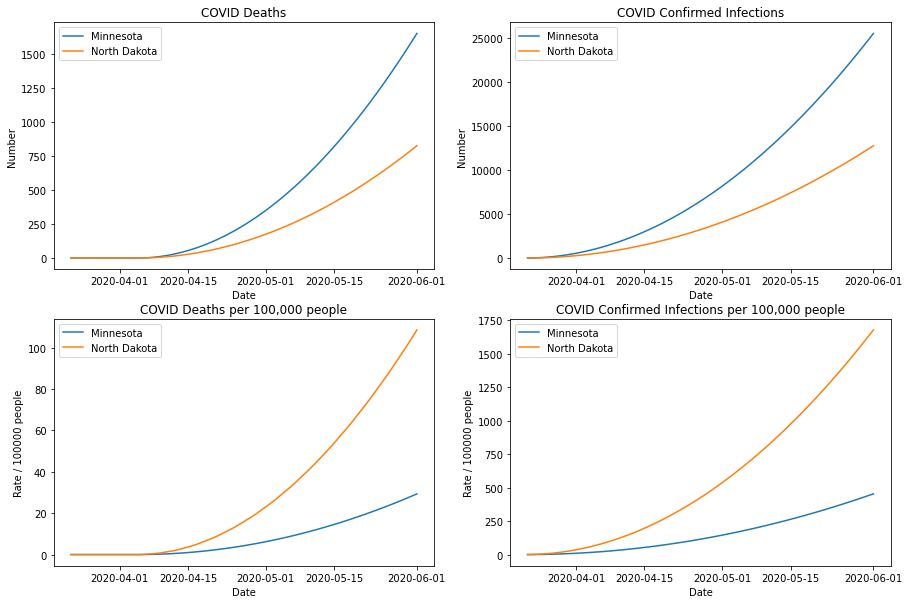

In [10]:
#
# I will pull the data to plot into numpy arrays (notice I have to use [0] because it comes out at list of lists even for single row)
#

# State-level data for plotting
dates_state = np.array(combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['Dates'].to_list()[0], dtype='datetime64')
MN_deaths = np.array(combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['Deaths'].to_list()[0],dtype='int')
MN_death_rate = (MN_deaths/combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['PopEst2019'].values)*100000
ND_deaths = np.array(combined_state_df[(combined_state_df['FIPS'] == NDFIPS)]['Deaths'].to_list()[0],dtype='int')
ND_death_rate = (ND_deaths/combined_state_df[(combined_state_df['FIPS'] == NDFIPS)]['PopEst2019'].values)*100000
MN_confirmed = np.array(combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['Confirmed'].to_list()[0],dtype='int')
MN_confirmed_rate = (MN_confirmed/combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['PopEst2019'].values)*100000
ND_confirmed = np.array(combined_state_df[(combined_state_df['FIPS'] == NDFIPS)]['Confirmed'].to_list()[0],dtype='int')
ND_confirmed_rate = (ND_confirmed/combined_state_df[(combined_state_df['FIPS'] == NDFIPS)]['PopEst2019'].values)*100000

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))

# Plot up deaths and death rates as plots 0 and 1
this_axs = axs[0, 0]  # Row 0, column 0
this_axs.plot(dates_state, MN_deaths, label='Minnesota')
this_axs.plot(dates_state, ND_deaths, label='North Dakota')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Number")
title = this_axs.set_title("COVID Deaths")

this_axs = axs[1, 0]  # Row 1, column 0
this_axs.plot(dates_state, MN_death_rate, label='Minnesota')
this_axs.plot(dates_state, ND_death_rate, label='North Dakota')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Rate / 100000 people")
title = this_axs.set_title("COVID Deaths per 100,000 people")

# Plot up confirmed infections and infection rates as plots 2 and 3
this_axs = axs[0, 1]  # Row 0, column 1
this_axs.plot(dates_state, MN_confirmed, label='Minnesota')
this_axs.plot(dates_state, ND_confirmed, label='North Dakota')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Number")
title = this_axs.set_title("COVID Confirmed Infections")

this_axs = axs[1, 1]  # Row 1, column 1
this_axs.plot(dates_state, MN_confirmed_rate, label='Minnesota')
this_axs.plot(dates_state, ND_confirmed_rate, label='North Dakota')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Rate / 100000 people")
title = this_axs.set_title("COVID Confirmed Infections per 100,000 people")

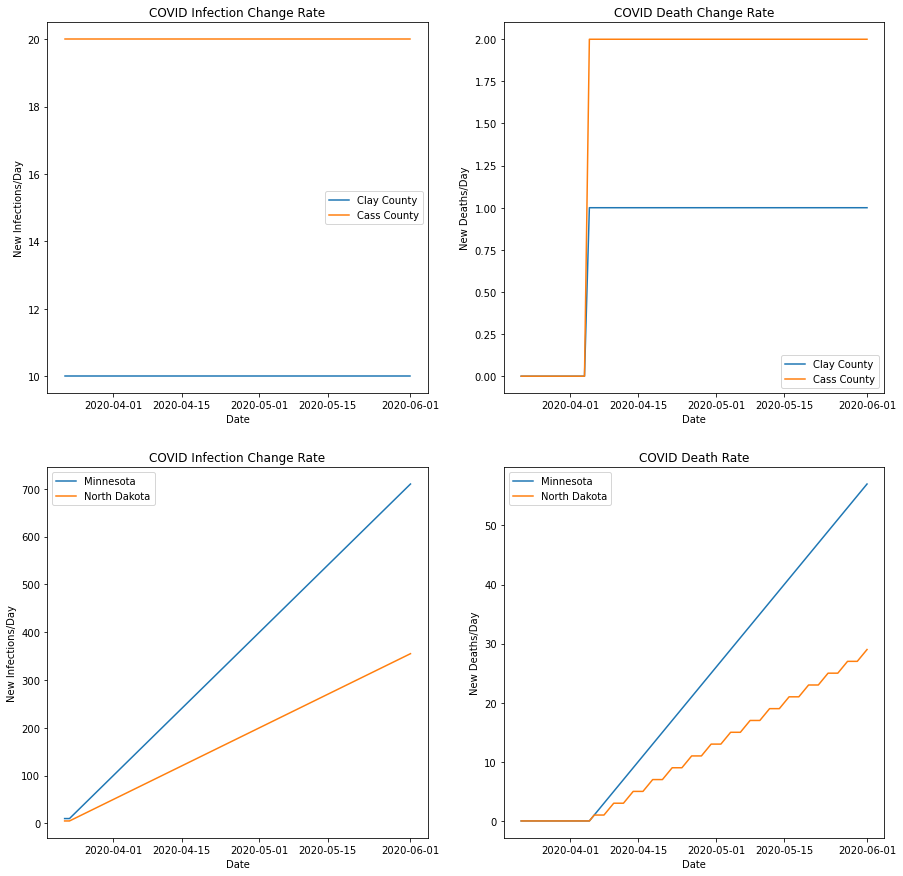

In [11]:
# Show demonstrations of plotting this data here by producing plots of data for Cass and Clay counties and North Dakota and Minnesota

#
# I will pull the data to plot into numpy arrays (notice I have to use [0] because it comes out at list of lists even for single row)
#

# County-level data for plotting
dates_cty = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['Dates'].to_list()[0], dtype='datetime64')
clay_ddeaths = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['dDeaths'].to_list()[0])
cass_ddeaths = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == CassFIPS)]['dDeaths'].to_list()[0])
clay_dconfirmed = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['dConfirmed'].to_list()[0])
cass_dconfirmed = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == CassFIPS)]['dConfirmed'].to_list()[0])

# State-level data for plotting
dates_state = np.array(combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['Dates'].to_list()[0], dtype='datetime64')
MN_ddeaths = np.array(combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['dDeaths'].to_list()[0])
ND_ddeaths = np.array(combined_state_df[(combined_state_df['FIPS'] == NDFIPS)]['dDeaths'].to_list()[0])
MN_dconfirmed = np.array(combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['dConfirmed'].to_list()[0])
ND_dconfirmed = np.array(combined_state_df[(combined_state_df['FIPS'] == NDFIPS)]['dConfirmed'].to_list()[0])

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Plot up the deriviates in the infection and death rates for counties
this_axs = axs[0, 0]  # row 0, column 0
this_axs.plot(dates_cty, clay_dconfirmed, label='Clay County')
this_axs.plot(dates_cty, cass_dconfirmed, label='Cass County')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("New Infections/Day")
title = this_axs.set_title("COVID Infection Change Rate")

this_axs = axs[0, 1]  # row 0, column 1
this_axs.plot(dates_cty, clay_ddeaths, label='Clay County')
this_axs.plot(dates_cty, cass_ddeaths, label='Cass County')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("New Deaths/Day")
title = this_axs.set_title("COVID Death Change Rate")

# Plot up the deriviates in the infection and death rates for states
this_axs = axs[1, 0]  # row 1, column 0
this_axs.plot(dates_state, MN_dconfirmed, label='Minnesota')
this_axs.plot(dates_state, ND_dconfirmed, label='North Dakota')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("New Infections/Day")
title = this_axs.set_title("COVID Infection Change Rate")

this_axs = axs[1, 1]  # row 1, column 1
this_axs.plot(dates_state, MN_ddeaths, label='Minnesota')
this_axs.plot(dates_state, ND_ddeaths, label='North Dakota')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("New Deaths/Day")
title = this_axs.set_title("COVID Death Rate")

## Generate Test Google Mobility Data 

In [12]:
# Retrieve the Google Mobility dataframes
(goog_mobility_cnty_df, goog_mobility_states_df) = COVIDdata.retrieve_goog_mobility_data(cnty_pop_df, state_pop_df)

/Users/juan/miniconda3/envs/astro37/lib/python3.7/site-packages/pandas/core/indexes/base.py:122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = op(self.values, np.asarray(other))


In [13]:
# Create test subsets containing only local data
test_goog_mobility_cnty_df= goog_mobility_cnty_df[(goog_mobility_cnty_df['FIPS'] == ClayFIPS) | (goog_mobility_cnty_df['FIPS'] == CassFIPS)].copy()
test_goog_mobility_states_df= goog_mobility_states_df[(goog_mobility_states_df['FIPS'] == MNFIPS) | (goog_mobility_states_df['FIPS'] == NDFIPS)].copy()

#
# Create test county data
#

npts = 100  # Output only the first hundred days

# Generate sine waves with amplitude 20 and different wavelengths in days
dates_CLAY = test_goog_mobility_cnty_df['dates'][(goog_mobility_cnty_df['FIPS'] == ClayFIPS)].tolist()[0]
dates_CASS = test_goog_mobility_cnty_df['dates'][(goog_mobility_cnty_df['FIPS'] == CassFIPS)].tolist()[0]
test_goog_mobility_cnty_df['dates'] = [dates_CLAY[0:npts], dates_CASS[0:npts]]

ptsCLAY = np.arange(npts)
ptsCASS = np.arange(npts)

wl = 30 # Wavelength of 30 days
amp = 20
signalCLAY = np.around(amp*np.sin(2 * np.pi * ptsCLAY/wl), decimals=3)
signalCASS = np.around((amp/2)*np.sin(2 * np.pi * ptsCASS/(wl*2)), decimals=3)
signalCLAY_list = signalCLAY.tolist()
signalCASS_list = signalCASS.tolist()
test_goog_mobility_cnty_df['retail_and_recreation_percent_change_from_baseline'] = [signalCLAY_list[0:npts], signalCASS_list[0:npts]]
test_goog_mobility_cnty_df['grocery_and_pharmacy_percent_change_from_baseline'] = [signalCLAY_list[0:npts], signalCASS_list[0:npts]]
signalCLAY /= 2
signalCASS /= 2
signalCLAY_list = signalCLAY.tolist()
null_list = len(signalCLAY_list)*[np.nan]
signalCASS_list = signalCASS.tolist()
test_goog_mobility_cnty_df['parks_percent_change_from_baseline'] = [signalCLAY_list[0:npts], signalCASS_list[0:npts]]
test_goog_mobility_cnty_df['transit_stations_percent_change_from_baseline'] = [null_list[0:npts], signalCASS_list[0:npts]]
signalCLAY /= 2
signalCASS /= 2
signalCLAY_list = signalCLAY.tolist()
signalCASS_list = signalCASS.tolist()
test_goog_mobility_cnty_df['workplaces_percent_change_from_baseline'] = [signalCLAY_list[0:npts], signalCASS_list[0:npts]]
test_goog_mobility_cnty_df['residential_percent_change_from_baseline'] = [signalCLAY_list[0:npts], signalCASS_list[0:npts]]

#
# Create test state data
#

# Generate cosine waves with amplitude 20 and different wavelengths in days
dates_MN = test_goog_mobility_states_df['dates'][(test_goog_mobility_states_df['FIPS'] == MNFIPS)].tolist()[0]
dates_ND = test_goog_mobility_states_df['dates'][(test_goog_mobility_states_df['FIPS'] == NDFIPS)].tolist()[0]
test_goog_mobility_states_df['dates'] = [dates_MN[0:npts], dates_ND[0:npts]]

pts_MN = np.arange(npts)
pts_ND = np.arange(npts)

wl = 30 # Wavelength of 30 days
amp = 20
signalMN = np.around(amp*np.cos(2 * np.pi * pts_MN/wl), decimals=3)
signalND = np.around((amp/2)*np.cos(2 * np.pi * pts_ND/(wl*2)), decimals=3)
signalMN_list = signalMN.tolist()
signalND_list = signalND.tolist()
test_goog_mobility_states_df['retail_and_recreation_percent_change_from_baseline'] = [signalMN_list[0:npts], signalND_list[0:npts]]
test_goog_mobility_states_df['grocery_and_pharmacy_percent_change_from_baseline'] = [signalMN_list[0:npts], signalND_list[0:npts]]
signalMN /= 2
signalND /= 2
signalMN_list = signalMN.tolist()
null_list = len(signalMN_list)*[np.nan]
signalND_list = signalND.tolist()
test_goog_mobility_states_df['parks_percent_change_from_baseline'] = [signalMN_list[0:npts], signalND_list[0:npts]]
test_goog_mobility_states_df['transit_stations_percent_change_from_baseline'] = [null_list[0:npts], signalND_list[0:npts]]
signalMN /= 2
signalND /= 2
signalMN_list = signalMN.tolist()
signalND_list = signalND.tolist()
test_goog_mobility_states_df['workplaces_percent_change_from_baseline'] = [signalMN_list[0:npts], signalND_list[0:npts]]
test_goog_mobility_states_df['residential_percent_change_from_baseline'] = [signalMN_list[0:npts], signalND_list[0:npts]]

In [14]:
# Export the test google mobility data to CSV files
print("Exporting test Google mobility data")
    
goog_mobility_cnty_fname = test_dir + "TEST_goog_mobility_cnty.csv"
print(" - Test Google county level mobility data exported to ", goog_mobility_cnty_fname)
test_goog_mobility_cnty_df.to_csv(goog_mobility_cnty_fname, index=False)

goog_mobility_states_fname = test_dir + "TEST_goog_mobility_state.csv"
print(" - Test Google state level mobility data exported to ", goog_mobility_states_fname)
test_goog_mobility_states_df.to_csv(goog_mobility_states_fname, index=False)


#
# Save the same data to pickle files
#
goog_mobility_cnty_fname = test_dir + "TEST_goog_mobility_cnty.p"
print(" - Test Google county level mobility data also exported to ", goog_mobility_cnty_fname)
with open(goog_mobility_cnty_fname, 'wb') as pickle_file:
    pickle.dump(test_goog_mobility_cnty_df, pickle_file)
    pickle_file.close()

goog_mobility_states_fname = test_dir + "TEST_goog_mobility_state.p"
print(" - Test Google state level mobility data also exported to ", goog_mobility_states_fname)
with open(goog_mobility_states_fname, 'wb') as pickle_file:
    pickle.dump(test_goog_mobility_states_df, pickle_file)
    pickle_file.close()

Exporting test Google mobility data
 - Test Google county level mobility data exported to  test_data/TEST_goog_mobility_cnty.csv
 - Test Google state level mobility data exported to  test_data/TEST_goog_mobility_state.csv
 - Test Google county level mobility data also exported to  test_data/TEST_goog_mobility_cnty.p
 - Test Google state level mobility data also exported to  test_data/TEST_goog_mobility_state.p


## Generate Test Apple Mobility Data

In [15]:
# Retrieve the Apple Mobility dataframes
(aapl_mobility_cnty_df, aapl_mobility_states_df) = COVIDdata.retrieve_aapl_mobility_data(cnty_pop_df, state_pop_df)

In [16]:
# Create test subsets containing only local data
test_aapl_mobility_cnty_df= aapl_mobility_cnty_df[(aapl_mobility_cnty_df['FIPS'] == ClayFIPS) | (aapl_mobility_cnty_df['FIPS'] == CassFIPS)].copy()
test_aapl_mobility_states_df= aapl_mobility_states_df[(aapl_mobility_states_df['FIPS'] == MNFIPS) | (aapl_mobility_states_df['FIPS'] == NDFIPS)].copy()

#
# Create test county data that is a sawtooth 1 week in duration
#

npts = 100  # Output only the first hundred days

dates_CLAY = test_aapl_mobility_cnty_df['dates'][(test_aapl_mobility_cnty_df['FIPS'] == ClayFIPS)].tolist()[0]
dates_CASS = test_aapl_mobility_cnty_df['dates'][(test_aapl_mobility_cnty_df['FIPS'] == CassFIPS)].tolist()[0]
test_aapl_mobility_cnty_df['dates'] = [dates_CLAY[0:npts], dates_CASS[0:npts]]

sawtooth = 30*(-3*np.ones(7)+np.arange(7))
sawtooth_inv = -1*sawtooth
signalCLAY = sawtooth.tolist()[0:npts]
signalCASS = sawtooth_inv.tolist()[0:npts]
test_aapl_mobility_cnty_df['driving_mobility'] = [signalCLAY, signalCASS]

#
# Create test state data that is a boxcar 8 days in duration
#

dates_MN = test_aapl_mobility_states_df['dates'][(test_aapl_mobility_states_df['FIPS'] == MNFIPS)].tolist()[0]
dates_ND = test_aapl_mobility_states_df['dates'][(test_aapl_mobility_states_df['FIPS'] == NDFIPS)].tolist()[0]
test_aapl_mobility_states_df['dates'] = [dates_MN[0:npts], dates_ND[0:npts]]

box = [1,1,1,1,-1,-1,-1,-1]
boxcar = 30*np.array(box)
boxcar_inv = -0.5*boxcar
signalMN = boxcar.tolist()[0:npts]
signalND = boxcar_inv.tolist()[0:npts]
test_aapl_mobility_states_df['driving_mobility'] = [signalMN, signalND]

In [17]:
# Export the test Apple mobility data to CSV files
print("\nExporting Test Apple mobility data")
    
aapl_mobility_cnty_fname = test_dir + "TEST_aapl_mobility_cnty.csv"
print(" - Apple county level mobility test data exported to ", aapl_mobility_cnty_fname)
test_aapl_mobility_cnty_df.to_csv(aapl_mobility_cnty_fname, index=False)

aapl_mobility_states_fname = test_dir + "TEST_aapl_mobility_state.csv"
print(" - Apple state level mobility test data exported to ", aapl_mobility_states_fname)
test_aapl_mobility_states_df.to_csv(aapl_mobility_states_fname, index=False)


#
# Save the same data to pickle files
#
aapl_mobility_cnty_fname = test_dir + "TEST_aapl_mobility_cnty.p"
print(" - Apple county level mobility test data also exported to ", aapl_mobility_cnty_fname)
with open(aapl_mobility_cnty_fname, 'wb') as pickle_file:
    pickle.dump(test_aapl_mobility_cnty_df, pickle_file)
    pickle_file.close()

aapl_mobility_states_fname = test_dir + "TEST_aapl_mobility_state.p"
print(" - Apple state level mobility test data also exported to ", aapl_mobility_states_fname)
with open(aapl_mobility_states_fname, 'wb') as pickle_file:
    pickle.dump(test_aapl_mobility_states_df, pickle_file)
    pickle_file.close()


Exporting Test Apple mobility data
 - Apple county level mobility test data exported to  test_data/TEST_aapl_mobility_cnty.csv
 - Apple state level mobility test data exported to  test_data/TEST_aapl_mobility_state.csv
 - Apple county level mobility test data also exported to  test_data/TEST_aapl_mobility_cnty.p
 - Apple state level mobility test data also exported to  test_data/TEST_aapl_mobility_state.p


## Generating IMHE Data

In [18]:
# Retrieve IMHE data
(imhe_summary, imhe_hospitalizations) = COVIDdata.retrieve_imhe_data(cnty_pop_df, state_pop_df)

## Summary data includes numbers or dates for the following for each state
#             'peak_bed_day_mean', 'peak_bed_day_lower', 'peak_bed_day_upper': Mean/Lower/Upper Uncertainty peak bed use date
# 'peak_icu_bed_day_mean', 'peak_icu_bed_day_lower', 'peak_icu_bed_day_upper': Mean/Lower/Upper Uncertainty ICU bed use date
#          'peak_vent_day_mean', 'peak_vent_day_lower', 'peak_vent_day_upper': Mean/Lower/Upper Uncertainty Ventilator use date
#    'all_bed_capacity', 'icu_bed_capacity', 'all_bed_usage', 'icu_bed_usage': Number of beds/ICU beds/avg beds used/avg ICU beds used
#                          'travel_limit_start_date', 'travel_limit_end_date': Severe travel restrictions start/end dates
#                                'stay_home_start_date', 'stay_home_end_date': Stay at home order start/end dates
#                    'educational_fac_start_date', 'educational_fac_end_date': Educational facilities closure start/end dates
#      'any_gathering_restrict_start_date', 'any_gathering_restrict_end_date': Any gathering restrictions start/end dates
#                          'any_business_start_date', 'any_business_end_date': Any business closures start/end dates
#          'all_non-ess_business_start_date', 'all_non-ess_business_end_date': Non-essential businesses ordered to close start/end dates
#
# 'NaN' present for dates means it isn't known.

## Hospitalization data is time series date for the following projections by the IMHE:
#                             'allbed_mean', 'allbed_lower','allbed_upper': Predicted COVID beds needed with upper/lower bounds
#                            'ICUbed_mean', 'ICUbed_lower', 'ICUbed_upper': Predicted COVID ICU beds needed with upper/lower bounds
#                            'InvVen_mean', 'InvVen_lower', 'InvVen_upper': Predicted COVID ventilators needed with upper/lower bounds
#                            'deaths_mean', 'deaths_lower', 'deaths_upper': Predicted COVID daily deaths with upper/lower bounds
#                               'admis_mean', 'admis_lower', 'admis_upper': Predicted hospital admissions with upper/lower bounds
#                            'newICU_mean', 'newICU_lower', 'newICU_upper': Predicted new ICU admissions per day with upper/lower bounds
#                            'totdea_mean', 'totdea_lower', 'totdea_upper': Predicted COVID cumilative deaths with upper/lower bounds
# 'deaths_mean_smoothed', 'deaths_lower_smoothed', 'deaths_upper_smoothed': Smoothed version of predicted COVID daily deaths
# 'totdea_mean_smoothed', 'totdea_lower_smoothed', 'totdea_upper_smoothed': Smoothed version of cumilative COVID deaths
#                                   'total_tests_data_type', 'total_tests': observed/predicted tests and total number of tests
#                                                   'confirmed_infections': Observed confirmed infections only
#    'est_infections_mean', 'est_infections_lower', 'est_infections_upper': Predicted estimated infections with upper/lower bounds
#
# 'NaN' present for dates means it isn't known.



In [19]:
# Create test subsets containing only local data
test_imhe_summary = imhe_summary[(imhe_summary['FIPS'] == MNFIPS) | (imhe_summary['FIPS'] == NDFIPS)].copy()
test_imhe_hospitalizations = imhe_hospitalizations[(imhe_hospitalizations['FIPS'] == MNFIPS) | (imhe_hospitalizations['FIPS'] == NDFIPS)].copy()

# Set fixed values for all the test summary data
test_imhe_summary['peak_bed_day_mean'] = [ '2020-05-15', '2020-06-15']
test_imhe_summary['peak_bed_day_lower'] = [ '2020-05-01', '2020-06-01']
test_imhe_summary['peak_bed_day_upper'] = [ '2020-06-15', '2020-07-15']
test_imhe_summary['peak_icu_bed_day_mean'] = [ '2020-05-15', '2020-06-15']
test_imhe_summary['peak_icu_bed_day_lower'] = [ '2020-05-01', '2020-06-01']
test_imhe_summary['peak_icu_bed_day_upper'] = [ '2020-06-15', '2020-07-15']
test_imhe_summary['peak_vent_day_mean'] = [ '2020-05-15', '2020-06-15']
test_imhe_summary['peak_vent_day_lower'] = [ '2020-05-01', '2020-06-01']
test_imhe_summary['peak_vent_day_upper'] = [ '2020-06-15', '2020-07-15']
test_imhe_summary['all_bed_capacity'] = [ 2000, 1000 ]
test_imhe_summary['icu_bed_capacity'] = [ 200, 100 ]
test_imhe_summary['all_bed_usage'] = [ 2000, 1000 ]
test_imhe_summary['icu_bed_usage'] = [ 200, 100 ]
test_imhe_summary['travel_limit_start_date'] = [ '2020-03-01',  np.nan ]
test_imhe_summary['travel_limit_end_date'] = [ '2020-06-01', np.nan ]
test_imhe_summary['stay_home_start_date'] = [ '2020-03-01',  np.nan]
test_imhe_summary['stay_home_end_date'] = [ '2020-06-01',  np.nan ]
test_imhe_summary['educational_fac_start_date'] = [ '2020-03-01',  np.nan ]
test_imhe_summary['educational_fac_end_date'] = [ np.nan,  np.nan]
test_imhe_summary['any_gathering_restrict_start_date'] = [ '2020-03-01',  np.nan ]
test_imhe_summary['any_gathering_restrict_end_date'] = [ np.nan,  np.nan]
test_imhe_summary['any_business_start_date'] = [ '2020-03-01',  np.nan ]
test_imhe_summary['any_business_end_date'] = ['2020-06-01',  np.nan]
test_imhe_summary['all_non-ess_business_start_date'] = [ '2020-03-01',  np.nan ]
test_imhe_summary['all_non-ess_business_end_date'] = [ '2020-06-01',  np.nan]

# Set fixed values for test hospitalizations but for a limited date range

# Generate a test date range
date1 = date(2020, 3, 22)
date2 = date(2020, 8, 1)
dates = list(daterange(date1, date2))
allbed = np.arange(len(dates))*1000
allicu = allbed*0.1
allvent = allbed*0.05
test_imhe_hospitalizations['dates'] = 2*[dates] 
test_imhe_hospitalizations['allbed_mean'] = [allbed.astype(int).tolist(), (0.5*allbed).astype(int).tolist() ]
test_imhe_hospitalizations['allbed_lower'] = [ (0.9*allbed).astype(int).tolist(), (0.9*0.5*allbed).astype(int).tolist() ]
test_imhe_hospitalizations['allbed_upper'] = [ (1.1*allbed).astype(int).tolist(), (1.1*0.5*allbed).astype(int).tolist() ]
test_imhe_hospitalizations['ICUbed_mean'] = [allicu.astype(int).tolist(), (0.5*allicu).astype(int).tolist() ]
test_imhe_hospitalizations['ICUbed_lower'] = [ (0.9*allicu).astype(int).tolist(), (0.9*0.5*allicu).astype(int).tolist() ]
test_imhe_hospitalizations['ICUbed_upper'] = [ (1.1*allicu).astype(int).tolist(), (1.1*0.5*allicu).astype(int).tolist() ]
test_imhe_hospitalizations['InvVen_mean'] = [allvent.astype(int).tolist(), (0.5*allvent).astype(int).tolist() ]
test_imhe_hospitalizations['InvVen_lower'] = [ (0.9*allvent).astype(int).tolist(), (0.9*0.5*allvent).astype(int).tolist() ]
test_imhe_hospitalizations['InvVen_upper'] = [allvent.astype(int).tolist(), (0.5*allvent).astype(int).tolist() ]

# Assume constant 10 deaths/100 admits/20 ICU a day
deaths = np.ones(len(dates))*10
admits = np.ones(len(dates))*10
newicus = np.ones(len(dates))*10
test_imhe_hospitalizations['deaths_mean'] = [ deaths.astype(int).tolist(), deaths.astype(int).tolist() ]
test_imhe_hospitalizations['deaths_lower'] = [ (0.9*deaths).astype(int).tolist(), (0.8*deaths).astype(int).tolist() ]
test_imhe_hospitalizations['deaths_upper'] = [ (1.1*deaths).astype(int).tolist(), (1.2*deaths).astype(int).tolist() ]
test_imhe_hospitalizations['admis_mean'] = [ admits.astype(int).tolist(), admits.astype(int).tolist() ]
test_imhe_hospitalizations['admis_lower'] = [ (0.9*admits).astype(int).tolist(), (0.8*admits).astype(int).tolist() ]
test_imhe_hospitalizations['admis_upper'] = [ (1.1*admits).astype(int).tolist(), (1.2*admits).astype(int).tolist() ]
test_imhe_hospitalizations['newICU_mean'] = [ newicus.astype(int).tolist(), newicus.astype(int).tolist() ]
test_imhe_hospitalizations['newICU_lower'] = [ (0.9*newicus).astype(int).tolist(), (0.8*newicus).astype(int).tolist() ]
test_imhe_hospitalizations['newICU_upper'] = [ (1.1*newicus).astype(int).tolist(), (1.2*newicus).astype(int).tolist() ]

# Compute total deaths
cumildeaths = np.cumsum(deaths)
test_imhe_hospitalizations['totdea_mean'] = [ np.cumsum(deaths).astype(int).tolist(), np.cumsum(deaths).astype(int).tolist()]
test_imhe_hospitalizations['totdea_lower'] = [ np.cumsum(0.9*deaths).astype(int).tolist(), np.cumsum(0.8*deaths).astype(int).tolist() ]
test_imhe_hospitalizations['totdea_upper'] = [ np.cumsum(1.1*deaths).astype(int).tolist(), np.cumsum(1.2*deaths).astype(int).tolist() ]

# Don't bother with smoothing test data
test_imhe_hospitalizations['deaths_mean_smoothed'] = test_imhe_hospitalizations['deaths_mean']
test_imhe_hospitalizations['deaths_lower_smoothed'] = test_imhe_hospitalizations['deaths_lower']
test_imhe_hospitalizations['deaths_upper_smoothed'] = test_imhe_hospitalizations['deaths_upper']
test_imhe_hospitalizations['totdea_mean_smoothed'] = test_imhe_hospitalizations['totdea_mean']
test_imhe_hospitalizations['totdea_lower_smoothed'] = test_imhe_hospitalizations['totdea_lower']
test_imhe_hospitalizations['totdea_upper_smoothed'] = test_imhe_hospitalizations['totdea_upper']

# Assume no tests first 10 days, then 10000 tests a day (observed for first 90, then projected)
typelist = 10*[np.nan] + 90*['observed'] + (len(dates) - 100)*['predicted']
tests = 10*[np.nan] + (len(dates) - 10)*[10000]
test_imhe_hospitalizations['total_tests_data_type'] = [ typelist, typelist]
test_imhe_hospitalizations['total_tests'] = [ tests, tests]

# Infections should increase a 10 per day and 20 per day, make estimated rates 
infections = np.arange(len(dates))*10
infections = np.arange(len(dates))*10

test_imhe_hospitalizations['confirmed_infections'] = [ infections.astype(int).tolist(), (2*infections).astype(int).tolist()]
test_imhe_hospitalizations['est_infections_mean'] = [ infections.astype(int).tolist(), (2*infections).astype(int).tolist()]
test_imhe_hospitalizations['est_infections_lower'] = [ (0.8*infections).astype(int).tolist(), (1.95*infections).astype(int).tolist()]
test_imhe_hospitalizations['est_infections_upper'] = [ (1.2*infections).astype(int).tolist(), (2.05*infections).astype(int).tolist()]

In [20]:
# Write out CSV files to disk
imhe_summary_fname = test_dir + "TEST_imhe_summary.csv"
print(" - IMHE state level summary test data exported to ", imhe_summary_fname)
test_imhe_summary.to_csv(imhe_summary_fname, index=False)

imhe_hospitalizations_fname = test_dir + "TEST_imhe_hospitalizations.csv"
print(" - IMHE hospitalization level summary test data exported to ", imhe_summary_fname)
test_imhe_hospitalizations.to_csv(imhe_hospitalizations_fname, index=False)

#
# Save the same data to pickle files
#
imhe_summary_fname = test_dir + "TEST_imhe_summary.p"
print(" - IMHE state level summary test data also exported to ", imhe_summary_fname)
with open(imhe_summary_fname, 'wb') as pickle_file:
    pickle.dump(test_imhe_summary, pickle_file)
    pickle_file.close()

imhe_hospitalizations_fname = test_dir + "TEST_imhe_hospitalizations.p"
print(" - IMHE hospitalization level summary test data also exported to ", imhe_summary_fname)
with open(imhe_hospitalizations_fname, 'wb') as pickle_file:
    pickle.dump(test_imhe_hospitalizations, pickle_file)
    pickle_file.close()

 - IMHE state level summary test data exported to  test_data/TEST_imhe_summary.csv
 - IMHE hospitalization level summary test data exported to  test_data/TEST_imhe_summary.csv
 - IMHE state level summary test data also exported to  test_data/TEST_imhe_summary.p
 - IMHE hospitalization level summary test data also exported to  test_data/TEST_imhe_summary.p


In [21]:
# Mark the start of processing
end = time.perf_counter()

print(f"Entire process of executing this script took {end-start:0.2f} sec.")

Entire process of executing this script took 63.55 sec.
